In [1]:
import pandas as pd
data = {'max_temp': []}
output = pd.DataFrame(data)

In [2]:
df = pd.read_csv(r'/content/CHI.csv')

In [3]:
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas

In [4]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://api.open-meteo.com/v1/forecast"
params = {
	"latitude": 41.85,
	"longitude": -87.65,
	"hourly": ["temperature_2m", "relative_humidity_2m", "precipitation", "rain", "snowfall", "wind_speed_10m", "wind_gusts_10m"],
	"daily": "temperature_2m_max",
	"start_date": "2024-04-04",
	"end_date": "2024-04-04"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(2).ValuesAsNumpy()
hourly_rain = hourly.Variables(3).ValuesAsNumpy()
hourly_snowfall = hourly.Variables(4).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(5).ValuesAsNumpy()
hourly_wind_gusts_10m = hourly.Variables(6).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["precipitation"] = hourly_precipitation
hourly_data["rain"] = hourly_rain
hourly_data["snowfall"] = hourly_snowfall
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["wind_gusts_10m"] = hourly_wind_gusts_10m

hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}
daily_data["temperature_2m_max"] = daily_temperature_2m_max

daily_dataframe = pd.DataFrame(data = daily_data)
print(daily_dataframe)

Coordinates 41.85271072387695°N -87.65362548828125°E
Elevation 179.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
                        date  temperature_2m  relative_humidity_2m  \
0  2024-04-04 00:00:00+00:00          2.0695                  93.0   
1  2024-04-04 01:00:00+00:00          2.5195                  92.0   
2  2024-04-04 02:00:00+00:00          2.7195                  90.0   
3  2024-04-04 03:00:00+00:00          2.6695                  95.0   
4  2024-04-04 04:00:00+00:00          2.6695                  93.0   
5  2024-04-04 05:00:00+00:00          2.2695                  92.0   
6  2024-04-04 06:00:00+00:00          2.2195                  90.0   
7  2024-04-04 07:00:00+00:00          2.2695                  89.0   
8  2024-04-04 08:00:00+00:00          2.5695                  91.0   
9  2024-04-04 09:00:00+00:00          2.5195                  92.0   
10 2024-04-04 10:00:00+00:00          2.4695                  88.0   
11 2024-04-04 11:00:00+00:00     

In [5]:
hourly_dataframe.drop(columns=['date'],inplace=True)

In [6]:
print(df)

                            date  temperature_2m  relative_humidity_2m  \
0      2014-01-01 00:00:00+00:00         -9.2935             72.978630   
1      2014-01-01 01:00:00+00:00         -9.3435             74.764640   
2      2014-01-01 02:00:00+00:00         -9.3435             76.291280   
3      2014-01-01 03:00:00+00:00         -9.3435             78.159935   
4      2014-01-01 04:00:00+00:00         -9.1935             79.133420   
...                          ...             ...                   ...   
87667  2024-01-01 19:00:00+00:00          1.3565             60.096527   
87668  2024-01-01 20:00:00+00:00          1.3565             59.189873   
87669  2024-01-01 21:00:00+00:00          1.1065             58.452694   
87670  2024-01-01 22:00:00+00:00          0.1065             66.264175   
87671  2024-01-01 23:00:00+00:00         -1.3435             72.540950   

       dew_point_2m  precipitation  rain  snowfall  wind_speed_10m  \
0        -13.243500            0.2   0.0 

In [7]:
df.drop(columns=['wind_speed_100m'],inplace=True)

In [8]:
print(df.columns)

Index(['date', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'precipitation', 'rain', 'snowfall', 'wind_speed_10m',
       'wind_gusts_10m'],
      dtype='object')


In [9]:
df.drop(columns=['date'],inplace=True)

In [10]:
df

,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,rain,snowfall,wind_speed_10m,wind_gusts_10m
0,-9.2935,72.978630,-13.243500,0.2,0.0,0.14,2.305125,14.400000
1,-9.3435,74.764640,-12.993500,0.2,0.0,0.14,3.600000,14.040000
2,-9.3435,76.291280,-12.743500,0.3,0.0,0.21,5.315336,13.320000
3,-9.3435,78.159935,-12.443500,0.4,0.0,0.28,6.849467,15.840000
4,-9.1935,79.133420,-12.143499,0.4,0.0,0.28,10.390226,19.800000
...,...,...,...,...,...,...,...,...
87667,1.3565,60.096527,-5.543500,0.0,0.0,0.00,14.512064,24.840000
87668,1.3565,59.189873,-5.743500,0.0,0.0,0.00,14.830076,25.199999
87669,1.1065,58.452694,-6.143500,0.0,0.0,0.00,14.417988,24.480000
87670,0.1065,66.264175,-5.443500,0.0,0.0,0.00,13.339445,22.319998


In [11]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


X = df[['relative_humidity_2m', 'precipitation', 'rain', 'snowfall', 'wind_speed_10m', 'wind_gusts_10m']]
y = df['temperature_2m']

X = pd.DataFrame(X, columns=['relative_humidity_2m', 'precipitation', 'rain', 'snowfall', 'wind_speed_10m', 'wind_gusts_10m'])
y = pd.DataFrame(y, columns=['temperature_2m'])

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train, y_train, epochs=30, batch_size=32, verbose=1)
mse_lstm = model_lstm.evaluate(X_test, y_test)
print("Mean Squared Error (LSTM):", mse_lstm)


Epoch 1/30
2192/2192 [==============================] - 18s 6ms/step - loss: 0.0317
Epoch 2/30
2192/2192 [==============================] - 6s 3ms/step - loss: 0.0231
Epoch 3/30
2192/2192 [==============================] - 6s 3ms/step - loss: 0.0229
Epoch 4/30
2192/2192 [==============================] - 6s 3ms/step - loss: 0.0226
Epoch 5/30
2192/2192 [==============================] - 7s 3ms/step - loss: 0.0225
Epoch 6/30
2192/2192 [==============================] - 6s 3ms/step - loss: 0.0223
Epoch 7/30
2192/2192 [==============================] - 5s 3ms/step - loss: 0.0222
Epoch 8/30
2192/2192 [==============================] - 7s 3ms/step - loss: 0.0222
Epoch 9/30
2192/2192 [==============================] - 6s 3ms/step - loss: 0.0222
Epoch 10/30
2192/2192 [==============================] - 7s 3ms/step - loss: 0.0221
Epoch 11/30
2192/2192 [==============================] - 5s 2ms/step - loss: 0.0220
Epoch 12/30
2192/2192 [==============================] - 6s 3ms/step - loss: 0.0221


In [12]:
import numpy as np

for index, row in hourly_dataframe.iterrows():

    relative_humidity_2m = row['relative_humidity_2m']
    precipitation = row['precipitation']
    rain = row['rain']
    snowfall = row['snowfall']
    wind_speed_10m = row['wind_speed_10m']
    wind_gusts_10m = row['wind_gusts_10m']

    input_data = np.array([[relative_humidity_2m, precipitation, rain, snowfall, wind_speed_10m, wind_gusts_10m]])
    scale_input = scaler_x.transform(input_data)
    reshaped_input_data = scale_input.reshape((scale_input.shape[0], 1, scale_input.shape[1]))
    predicted_output = model_lstm.predict(reshaped_input_data)
    predicted_output = scaler_y.inverse_transform(predicted_output)
    output.at[index, 'max_temp'] = predicted_output[0][0]
print(output)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 1s/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 87ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 88ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 90ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 43ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 33ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 36ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 67ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 55ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 54ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 70ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 48ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 45ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 50ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 38ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 32ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 51ms/step
     max_temp
0   14.452825
1   11.846696
2   11.791752
3   11.657004
4   11.247906
5   12.540308
6   12.620215
7   11.324870
8   13.024609
9   12.769723
10  12.510427
11  10.265455
12  11.912815
13  10.900317
14  11.648344
15  13.020050
16  15.253935
17  15.010468
18  16.546995
19  11.857109
20  10.196555
21   8.573127
22  10.968292
23  12.020060


In [13]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

model_lstm = Sequential()
model_lstm.add(LSTM(50,
                    input_shape=(X_train.shape[1], X_train.shape[2]),
                    kernel_regularizer=regularizers.l2(0.01)))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

model_lstm.fit(X_train, y_train, epochs=60, batch_size=32, verbose=1)
mse_lstm = model_lstm.evaluate(X_test, y_test)
print("Mean Squared Error (LSTM):", mse_lstm)

Epoch 1/60
2192/2192 [==============================] - 19s 6ms/step - loss: 0.0375
Epoch 2/60
2192/2192 [==============================] - 8s 3ms/step - loss: 0.0256
Epoch 3/60
2192/2192 [==============================] - 6s 3ms/step - loss: 0.0252
Epoch 4/60
2192/2192 [==============================] - 7s 3ms/step - loss: 0.0250
Epoch 5/60
2192/2192 [==============================] - 7s 3ms/step - loss: 0.0249
Epoch 6/60
2192/2192 [==============================] - 7s 3ms/step - loss: 0.0248
Epoch 7/60
2192/2192 [==============================] - 6s 3ms/step - loss: 0.0247
Epoch 8/60
2192/2192 [==============================] - 7s 3ms/step - loss: 0.0246
Epoch 9/60
2192/2192 [==============================] - 6s 3ms/step - loss: 0.0244
Epoch 10/60
2192/2192 [==============================] - 6s 3ms/step - loss: 0.0242
Epoch 11/60
2192/2192 [==============================] - 7s 3ms/step - loss: 0.0240
Epoch 12/60
2192/2192 [==============================] - 6s 3ms/step - loss: 0.0240


In [14]:
import numpy as np

for index, row in hourly_dataframe.iterrows():

    relative_humidity_2m = row['relative_humidity_2m']
    precipitation = row['precipitation']
    rain = row['rain']
    snowfall = row['snowfall']
    wind_speed_10m = row['wind_speed_10m']
    wind_gusts_10m = row['wind_gusts_10m']

    input_data = np.array([[relative_humidity_2m, precipitation, rain, snowfall, wind_speed_10m, wind_gusts_10m]])
    scale_input = scaler_x.transform(input_data)
    reshaped_input_data = scale_input.reshape((scale_input.shape[0], 1, scale_input.shape[1]))
    predicted_output = model_lstm.predict(reshaped_input_data)
    predicted_output = scaler_y.inverse_transform(predicted_output)
    output.at[index, 'max_temp'] = predicted_output[0][0]
print(output)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 21ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 31ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 33ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 29ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 31ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 29ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 32ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 32ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 40ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 35ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 33ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 44ms/step
     max_temp
0   12.438555
1    9.600720
2   12.111466
3   11.711752
4   11.202400
5   13.184845
6   13.775330
7   11.449721
8   12.786534
9   11.893788
10  11.456803
11   9.082042
12  10.687289
13   9.971375
14  10.399407
15  11.522448
16  11.469893
17  11.452136
18  12.198181
19  10.557167
20   9.670940
21   8.607062
22  11.906261
23  12.164562


Here We take the max value of the temperature we obtained from our prediction

In [15]:
max_temp_max = output['max_temp'].max()

The next cell is the actual max temp recorded today obtained from the weather api

In [16]:
daily_dataframe.temperature_2m_max[0]

4.9694996

In [17]:
a=daily_dataframe.temperature_2m_max[0]
a=(a*9/5)+32
b=max_temp_max
c=(max_temp_max*9/5)+32
Offset_temp = max_temp_max-daily_dataframe.temperature_2m_max[0]
print("Offset_temp in Celsius is",b-daily_dataframe.temperature_2m_max[0])
print("Offset Temp in Farenheit is",c-a)

Offset_temp in Celsius is 8.805830001831055
Offset Temp in Farenheit is 15.8504940032959


 **Offset Temp mean how off the predicted values are from the actual values*

In [18]:
print(max_temp_max,"This is in Degree Celsius(Predicted)")
max_temp_max=(max_temp_max * 9/5) + 32
print(max_temp_max,"This is in Farenheit(Predicted)")

13.77532958984375 This is in Degree Celsius(Predicted)
56.79559326171875 This is in Farenheit(Predicted)


In [19]:
import json
data = {'max_temp_max': max_temp_max}
file_path = '/content/max_temp_max.json'
with open(file_path, 'w') as json_file:
    json.dump(data, json_file)

print("Value saved to", file_path)


Value saved to /content/max_temp_max.json


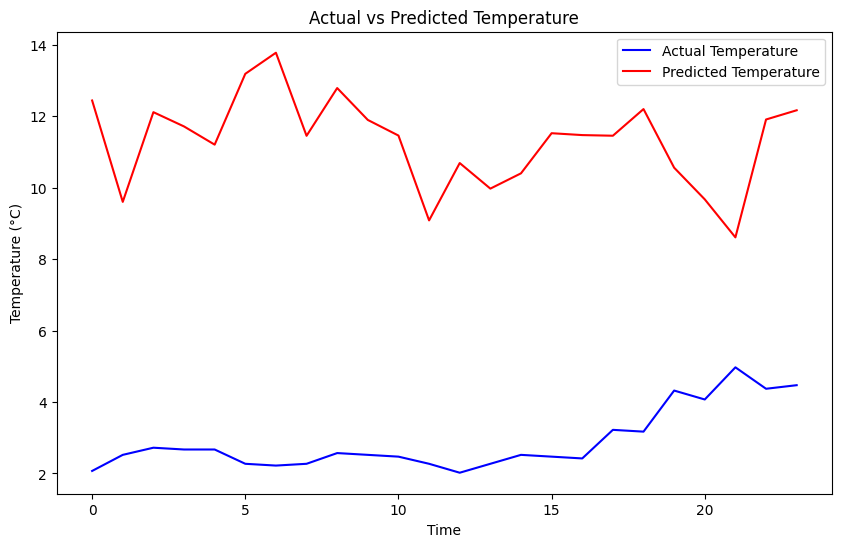

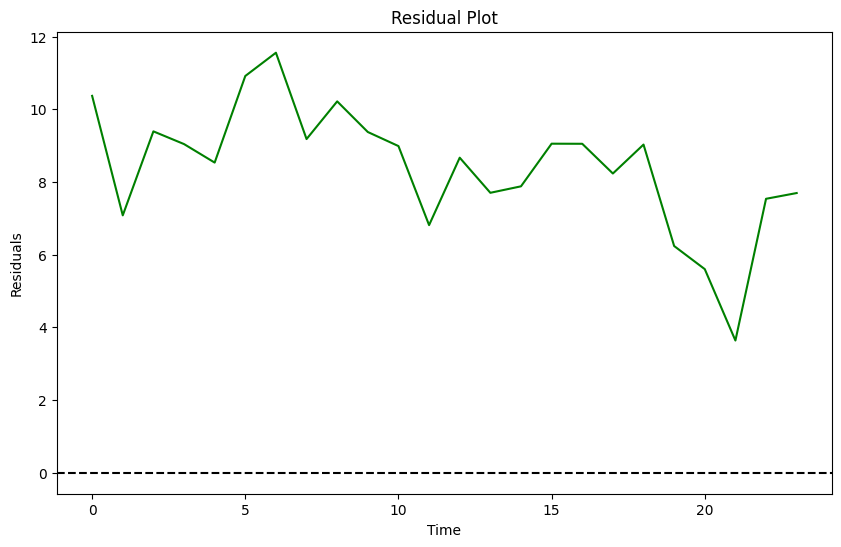

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(hourly_dataframe.index, hourly_dataframe['temperature_2m'], label='Actual Temperature', color='blue')
plt.plot(hourly_dataframe.index, output['max_temp'], label='Predicted Temperature', color='red')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Actual vs Predicted Temperature')
plt.legend()
plt.show()

residuals = output['max_temp'] - hourly_dataframe['temperature_2m']

plt.figure(figsize=(10, 6))
plt.plot(hourly_dataframe.index, residuals, color='green')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()



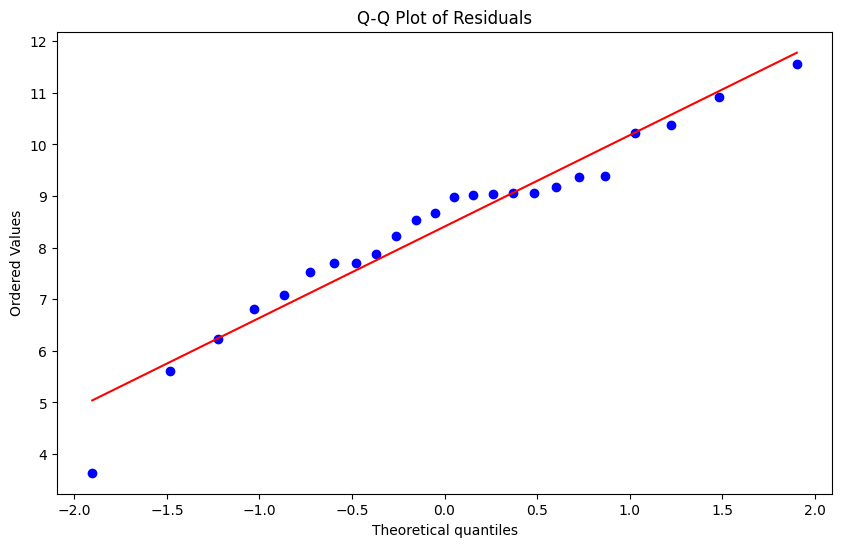

In [21]:
import scipy.stats as stats

plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()


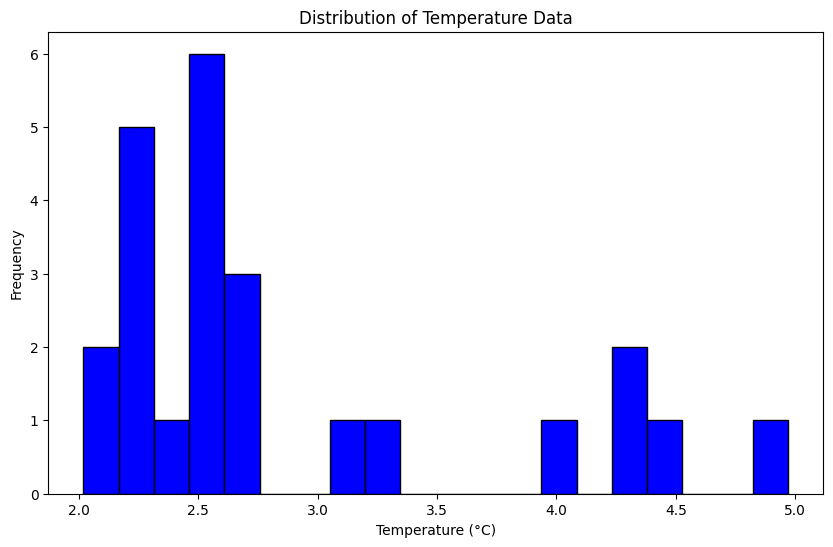

In [23]:
plt.figure(figsize=(10, 6))
plt.hist(hourly_dataframe['temperature_2m'], bins=20, color='blue', edgecolor='black')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.title('Distribution of Temperature Data')
plt.show()
